In [ ]:
import pandas as pd
from sklearn.metrics import root_mean_squared_error
from typing import List, Tuple
from xgboost import XGBRegressor 
import uuid
import datetime 
import time
from sklearn.model_selection import TimeSeriesSplit
from utils.output_analysis import plot_player_value_trends, save_output_tables
from utils.model import test_train_split, define_features, analysis_result , prepare_future_year_data, iterative_cap_predicted_value
from utils.xgboost_analysis import plot_basic_decision_tree, plot_feature_importance, create_shapley_values_plots
import optuna
from config import features, test_start, target, filter_out_synthetic
import os
import plotly.express as px


C:\Users\tomkn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
start = time.time()

In [3]:
pdf_mvp = pd.read_csv("data/intermediate/time_series_model_data_prep.csv") 

if filter_out_synthetic:
    print(pdf_mvp.shape)
    pdf_mvp = pdf_mvp[pdf_mvp["synthetic_flag"] == False]
    print(pdf_mvp.shape)

C:\Users\tomkn\AppData\Local\Temp\ipykernel_1020\4198838041.py:1: DtypeWarning: Columns (3,6,7,9,30,36) have mixed types. Specify dtype option on import or set low_memory=False.
  pdf_mvp = pd.read_csv("data/intermediate/time_series_model_data_prep.csv")


In [4]:
version  = "v0.0.8"
forecast_id = uuid.uuid4()

In [5]:

features = define_features(pdf_mvp, features)

pdf_train, pdf_test = test_train_split(pdf_mvp, test_start)

In [6]:
def objective(
    trial: optuna.Trial,
    X: pd.DataFrame,
    y: pd.Series,
    tscv: TimeSeriesSplit,
) -> float:
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),  # Number of trees
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),  # Learning rate
        "max_depth": trial.suggest_int("max_depth", 1, 7),  # Tree depth
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),  # Subsampling fraction
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),  # Min loss reduction for split
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),  # L1 regularization
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0),  # L2 regularization
        "random_state": 42,
        "objective": "reg:squarederror",
        "tree_method": "hist",
        "verbosity": 0,
    }

    rmse_scores = []

    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = XGBRegressor(**params)
        model.fit(X_train, y_train)

        preds = model.predict(X_val)
        rmse = root_mean_squared_error(y_val, preds)
        rmse_scores.append(rmse)

    return sum(rmse_scores) / len(rmse_scores)  # Average RMSE across folds


In [7]:

def predict_future_values(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    prediction_years: List[int],
    features: List[str],
    n_trials: int = 100,
) -> Tuple[pd.DataFrame, XGBRegressor, pd.Series]:
    """
    Predicts future player values for specified years using XGBoost and Optuna hyperparameter tuning.

    Args:
        train_df: Training DataFrame with features and target.
        test_df: Initial test DataFrame to predict from (starting year).
        prediction_years: List of years to predict, starting with the base year.
        features: List of feature column names to use.
        n_trials: Number of Optuna trials for hyperparameter search.

    Returns:
        Tuple of:
            - DataFrame with predicted values for all prediction years concatenated.
            - Trained XGBRegressor using best Optuna params.
            - y_test from the base year (only valid for the first year).
    """

    X_train = train_df[features]
    y_train = train_df[target]

    tscv = TimeSeriesSplit(n_splits=3)

    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, X_train, y_train, tscv), n_trials=n_trials, show_progress_bar=False)

    print(f"Best trial params: {study.best_trial.params}")
    print(f"Best trial RMSE: {study.best_value:.4f}")

    # Train final model on all training data with best params
    best_params = study.best_trial.params
    # Add fixed params required by XGBRegressor
    best_params.update({
        "random_state": 42,
        "objective": "reg:squarederror",
        "tree_method": "hist",
        "verbosity": 0,
    })

    model = XGBRegressor(**best_params)
    model.fit(X_train, y_train)

    predictions = []
    current_df = test_df.copy()

    for i, year in enumerate(prediction_years):
        X_test = current_df[features]
        current_df["predicted_value"] = model.predict(X_test)
        current_df["year"] = year

        if i == 0:
            y_test = current_df[target]
            analysis_result(current_df, y_test, year, target)
            create_shapley_values_plots(model, X_train, X_test, features)
            top_features = plot_feature_importance(model, features)
        else:
            current_df["age"] = current_df["age_last_year"] + 1

        # Reduce contract years left by 1, never below 0
        if "contract_years_left" in current_df.columns:
            current_df["contract_years_left"] = (current_df["contract_years_left"] - 1).clip(lower=0)

        current_df["age_last_year"] = current_df["age"]
        current_df["value_last_year"] = current_df["predicted_value"]

        predictions.append(current_df[["player_id", "year", "age", "predicted_value"]].copy())

        if i < len(prediction_years) - 1:
            current_df = prepare_future_year_data(current_df)

    all_predictions_df = pd.concat(predictions, ignore_index=True)
    return all_predictions_df, model, y_test, top_features

[I 2025-08-22 14:38:07,144] A new study created in memory with name: no-name-4556e767-273b-41e6-977e-90e9c287d9b3
[I 2025-08-22 14:38:08,204] Trial 0 finished with value: 5.337523587553353 and parameters: {'n_estimators': 144, 'learning_rate': 0.08580171106252261, 'max_depth': 5, 'subsample': 0.819970088393791, 'colsample_bytree': 0.6953867285615576, 'gamma': 3.553034001603843, 'reg_alpha': 0.5249589538850696, 'reg_lambda': 9.825478448754518}. Best is trial 0 with value: 5.337523587553353.
[I 2025-08-22 14:38:08,623] Trial 1 finished with value: 5.1350677846633745 and parameters: {'n_estimators': 51, 'learning_rate': 0.2840238236147786, 'max_depth': 5, 'subsample': 0.9774130981484173, 'colsample_bytree': 0.798787728047514, 'gamma': 0.8712133505688385, 'reg_alpha': 0.4184864184965539, 'reg_lambda': 1.4776203168553759}. Best is trial 1 with value: 5.1350677846633745.
[I 2025-08-22 14:38:09,006] Trial 2 finished with value: 6.756550280909454 and parameters: {'n_estimators': 174, 'learning

Best trial params: {'n_estimators': 101, 'learning_rate': 0.13273106554680542, 'max_depth': 3, 'subsample': 0.5873927183876223, 'colsample_bytree': 0.9604795570019913, 'gamma': 2.040118641196731, 'reg_alpha': 0.6920972836745483, 'reg_lambda': 2.759399545018516}
Best trial RMSE: 4.5989
2023 RMSE: 5.86
2023 R²: 0.853


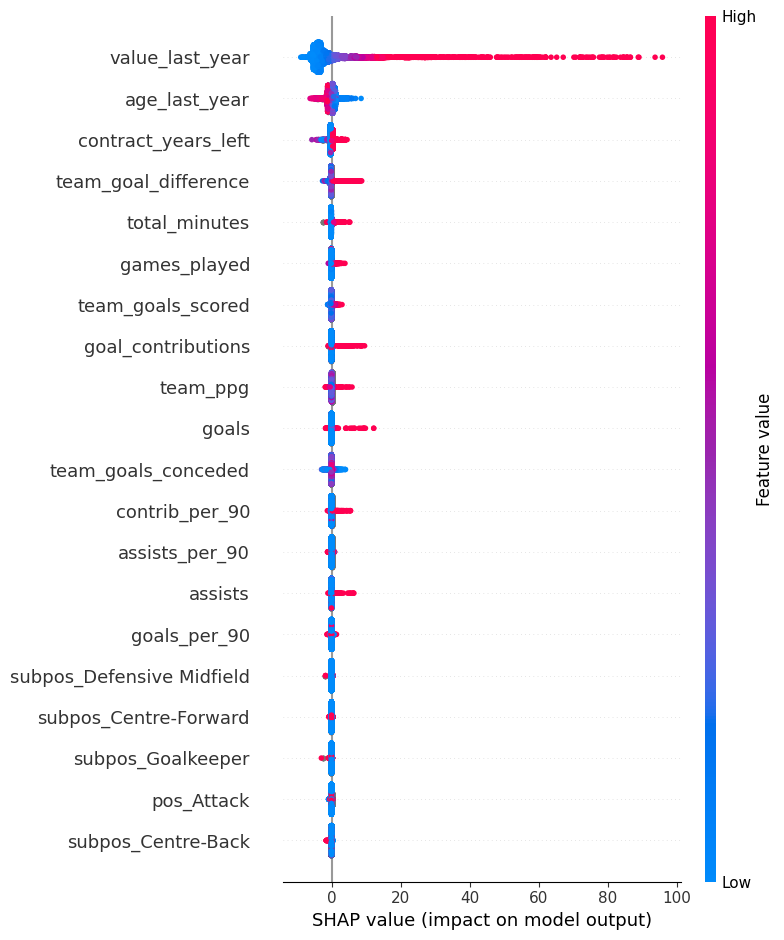

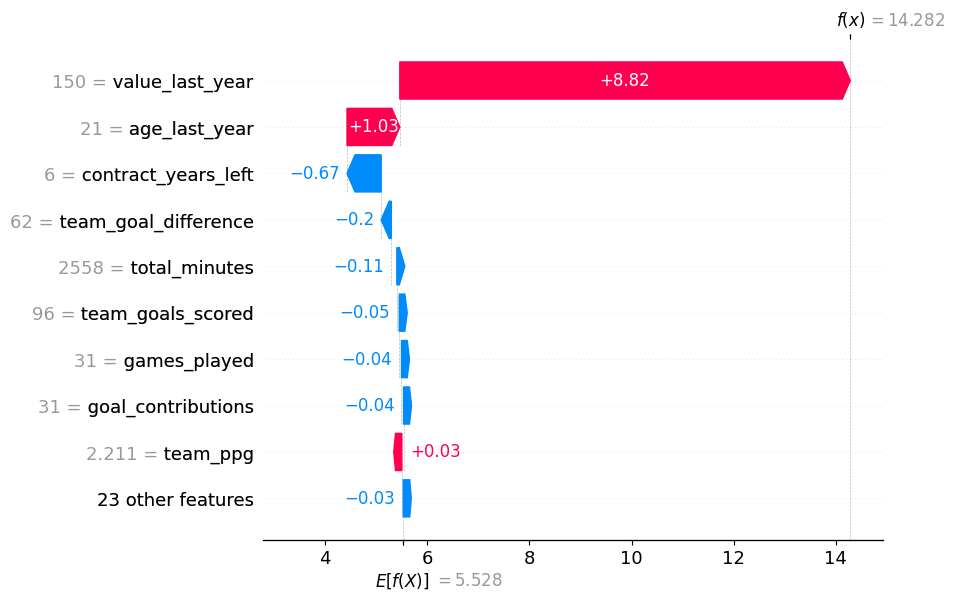

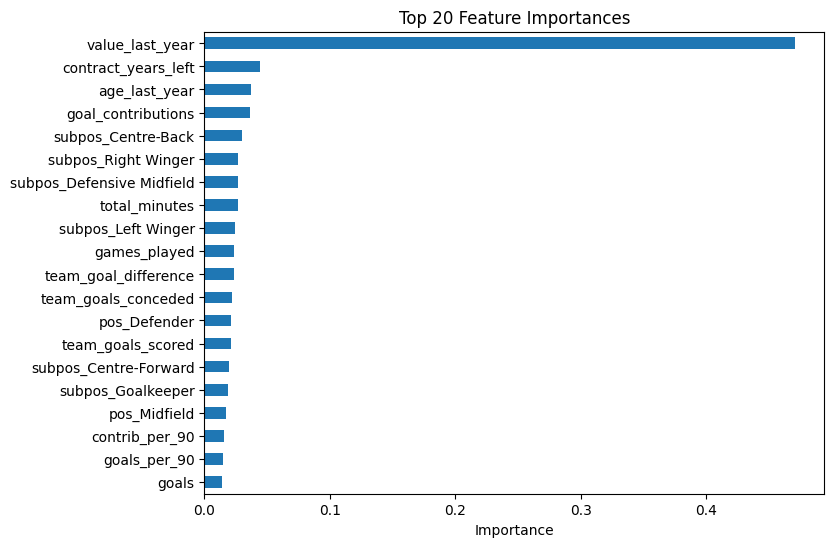

In [8]:
forecast_df, regressor, y_test, top_features = predict_future_values(    pdf_train, 
    pdf_test, [2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038], features)

In [9]:
# Merge with actual market values for evaluation

merged = forecast_df.merge(pdf_test[["player_id", "name"]], on=["player_id"], how="left")
end = time.time()
diff = end - start

In [11]:
players = [418560, 357662, 565822, 859951, 148455, 274839, 542580, 568177, 197838, 225693, 8198, 93176]

In [ ]:
#TODO - Renconsider the hard coding
merged_capped = iterative_cap_predicted_value(merged, age_limit=32, scale_limit=0.8)


In [15]:
agg_age = merged_capped.groupby(["age", "was_capped"])[["player_id"]].count().reset_index()

In [16]:
px.line(agg_age, x="age", y="player_id", color="was_capped", title="Capped vs Uncapped Predicted Values by Age")

In [17]:

plot_player_value_trends(
    pdf_train, merged_capped,
    player_ids=players
)




In [18]:
plot_player_value_trends(
    pdf_train, merged_capped,
    top_year=2025,
    top_n=10
)

In [21]:
output_df = merged_capped.query("year == 2023")
output_df["actual_value"] = y_test.values


C:\Users\tomkn\AppData\Local\Temp\ipykernel_1020\2420814704.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [25]:
pdf_feature_importance = top_features.reset_index()
pdf_feature_importance.columns = ["feature", "importance"]
pdf_feature_importance["model_output_id"] = forecast_id

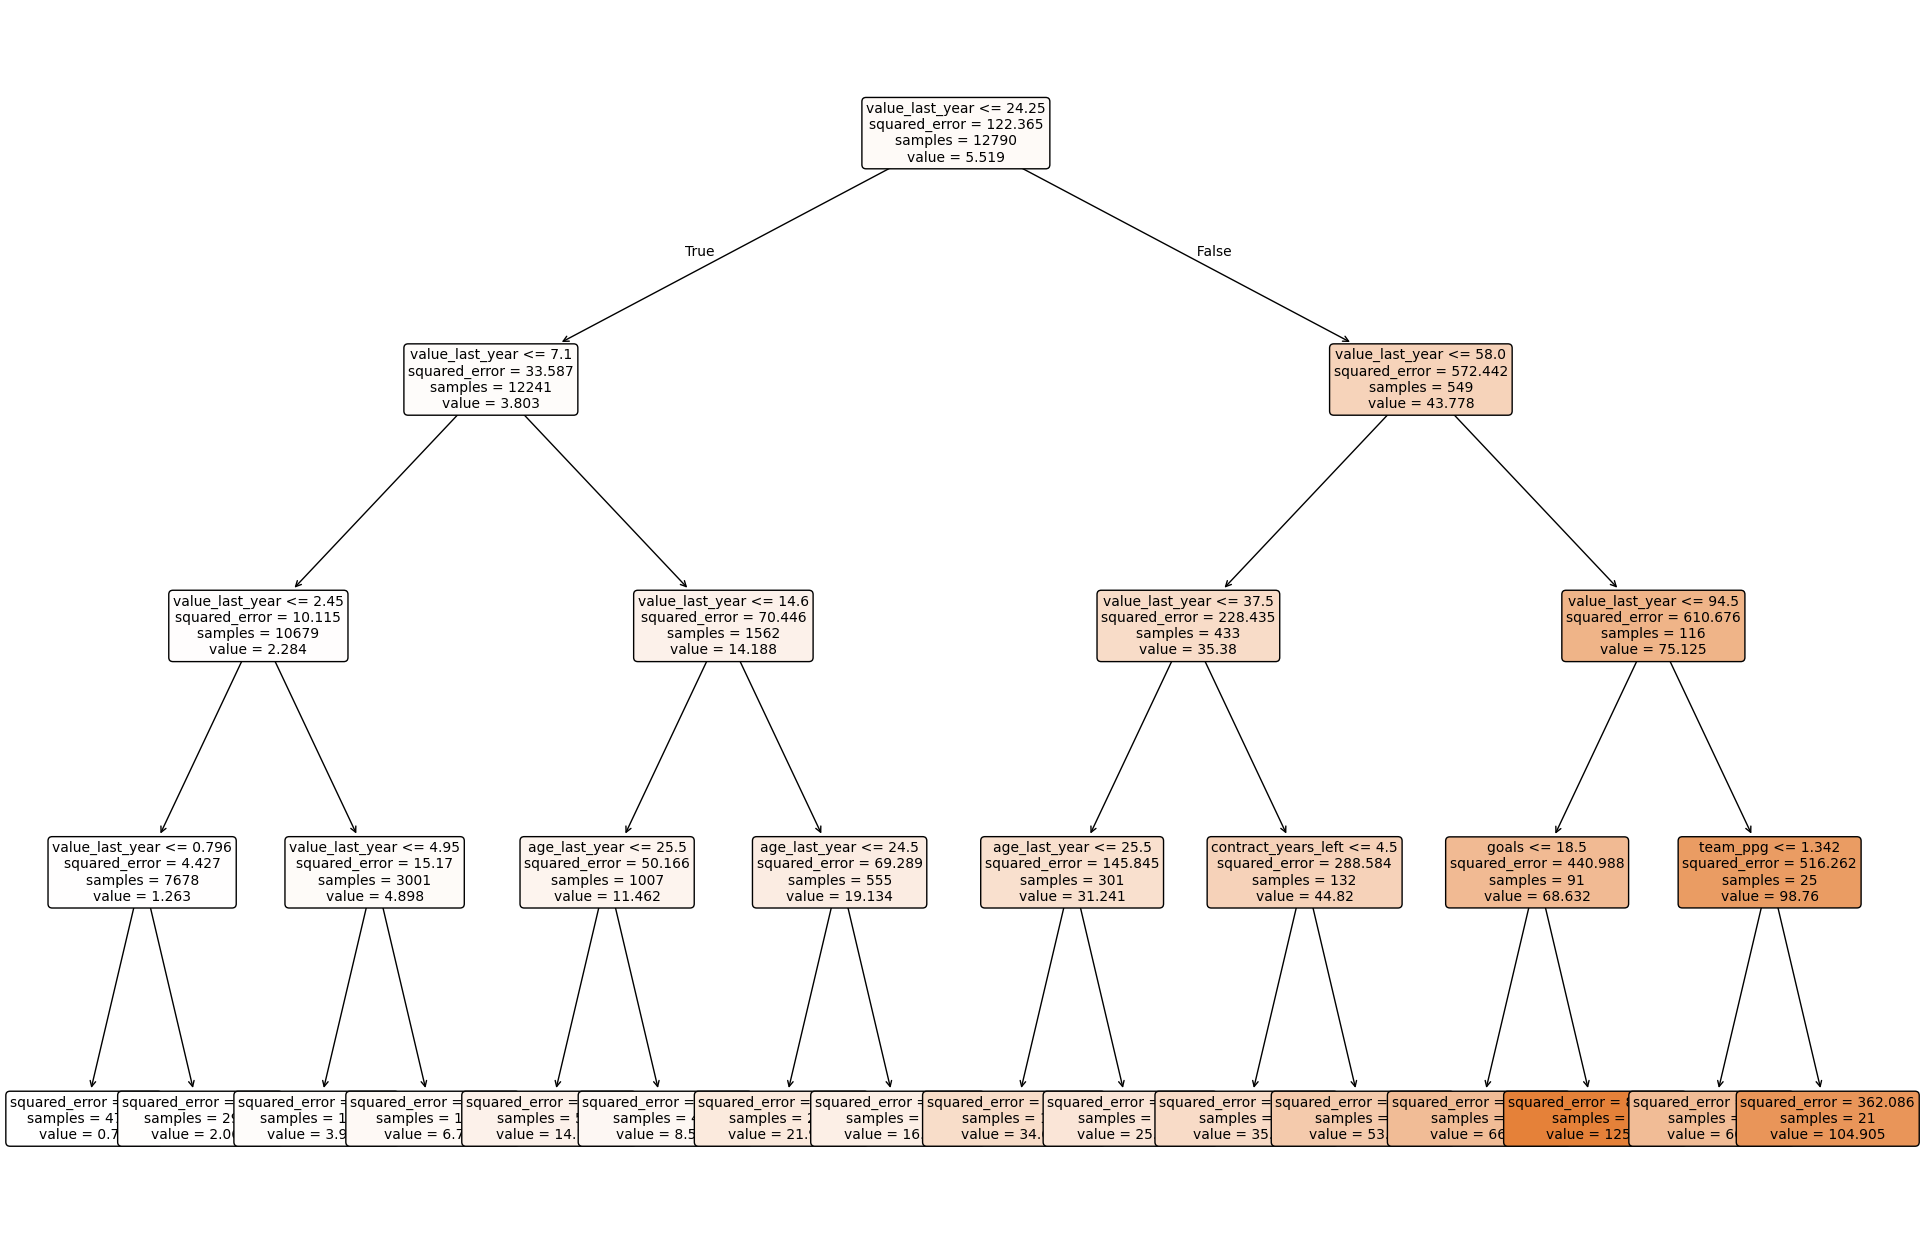

In [26]:



plot_basic_decision_tree(pdf_train, features, target, max_depth=4)

In [27]:
output_df["model_output_id"] = forecast_id
output_df["model_run_date"] = datetime.datetime.now()
output_df["time_taken_seconds"] = diff
output_df["features_used"] = str(features)
output_df["model_type"] = "XG_Boost"
output_df["split_year"] = test_start
output_df["version"] = version

C:\Users\tomkn\AppData\Local\Temp\ipykernel_1020\2774007858.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\tomkn\AppData\Local\Temp\ipykernel_1020\2774007858.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\tomkn\AppData\Local\Temp\ipykernel_1020\2774007858.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [28]:
save_output_tables(output_df)

In [29]:

feature_path = "data/output/feature_importance.csv"

# Check if files exist
feature_exists = os.path.isfile(feature_path)

# Append output
pdf_feature_importance.to_csv(feature_path, mode="a", index=False, header=not feature_exists)

